In [32]:
import os
import json
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 루트 경로 (네 환경에 맞게 수정)
ROOT = "../data/CarDD_COCO"
ann_path = os.path.join(ROOT, "annotations", "instances_test2017.json")
test_img_dir = os.path.join(ROOT, "test2017")

Device: cuda


In [33]:
import os
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: c:\Users\user\Documents\python_ws\cardd-image-classification-benchmark\notebooks


In [34]:
with open(ann_path, "r", encoding="utf-8") as f:
    test_coco = json.load(f)

images = test_coco["images"]
annotations = test_coco["annotations"]
categories = test_coco["categories"]

print(len(images), "images in JSON")
print(len(annotations), "annotations in JSON")
print(len(categories), "categories in JSON")

374 images in JSON
785 annotations in JSON
6 categories in JSON


In [35]:
# 가장 신뢰하는 모델 하나 선택
ckpt_path = "../models/resnet18_sampler.pth"  # 경로 수정

ckpt = torch.load(ckpt_path, map_location=device)

# 저장해뒀다면 이렇게 꺼내고, 없으면 직접 리스트 작성
class_names = ckpt.get("class_names", ["dent", "scratch", "crack", "glass shatter", "lamp broken", "tire flat"])
print(class_names)
num_classes = len(class_names)

['dent', 'scratch', 'crack', 'glass shatter', 'lamp broken', 'tire flat']


In [36]:
# COCO category_id -> name
coco_catid_to_name = {c["id"]: c["name"] for c in categories}
print(coco_catid_to_name)

# name -> class index (우리 학습용)
name_to_idx = {name: i for i, name in enumerate(class_names)}
print(name_to_idx)

# 최종: COCO category_id -> class index
catid_to_classidx = {}
for cid, cname in coco_catid_to_name.items():
    if cname not in name_to_idx:
        print("경고: COCO category", cname, "가 class_names에 없음!")
    else:
        catid_to_classidx[cid] = name_to_idx[cname]

print("catid_to_classidx:", catid_to_classidx)

{1: 'dent', 2: 'scratch', 3: 'crack', 4: 'glass shatter', 5: 'lamp broken', 6: 'tire flat'}
{'dent': 0, 'scratch': 1, 'crack': 2, 'glass shatter': 3, 'lamp broken': 4, 'tire flat': 5}
catid_to_classidx: {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5}


In [37]:
# image_id -> file_name
imgid_to_filename = {img["id"]: img["file_name"] for img in images}

# image_id -> class index (단일 라벨)
# 이미지에 annotation이 여러 개 있을 수도 있지만,
# "단일 라벨 분류"라고 했으니, 일단 첫 번째 annotation 기준으로 라벨을 정하자.
imgid_to_label = {}

for ann in annotations:
    img_id = ann["image_id"]
    cat_id = ann["category_id"]
    if cat_id not in catid_to_classidx:
        continue
    class_idx = catid_to_classidx[cat_id]

    # 아직 label이 안 정해진 image_id만 채우기 (첫 라벨 기준)
    if img_id not in imgid_to_label:
        imgid_to_label[img_id] = class_idx

print("라벨이 있는 이미지 수:", len(imgid_to_label))

라벨이 있는 이미지 수: 374


In [38]:
test_img_paths = []
test_labels = []

missing_files = 0

for img_id, label_idx in imgid_to_label.items():
    fname = imgid_to_filename[img_id]
    img_path = os.path.join(test_img_dir, fname)
    if os.path.exists(img_path):
        test_img_paths.append(img_path)
        test_labels.append(label_idx)
    else:
        missing_files += 1

print("test 샘플 수:", len(test_img_paths))
print("누락된 이미지 파일:", missing_files)

test 샘플 수: 374
누락된 이미지 파일: 0


In [39]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  # ImageNet 통계
        std=[0.229, 0.224, 0.225]
    ),
])

In [40]:
class CarddTestDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

In [41]:
batch_size = 32
num_workers = 0  # Windows일 때 0이 안전

test_dataset = CarddTestDataset(test_img_paths, test_labels, transform=test_transform)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers
)

len(test_dataset)

374

In [42]:
# 1) backbone에 따라 ResNet18 / ResNet34 생성
def build_model(backbone: str, num_classes: int, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if backbone == "resnet18":
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        model = models.resnet18(weights=weights)
    elif backbone == "resnet34":
        weights = models.ResNet34_Weights.IMAGENET1K_V1
        model = models.resnet34(weights=weights)
    else:
        raise ValueError(f"Unknown backbone: {backbone}")

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model.to(device)


# 2) checkpoint(.pth) 로드
def load_checkpoint(path: str, backbone: str, class_names, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    ckpt = torch.load(path, map_location=device)

    # ckpt에 class_names가 들어있으면 가져와서 확인
    ckpt_class_names = ckpt.get("class_names", class_names)
    if list(ckpt_class_names) != list(class_names):
        print("[경고] ckpt 안의 class_names와 지금 노트북의 class_names 순서가 다를 수 있습니다.")
        print("ckpt_class_names:", ckpt_class_names)

    model = build_model(backbone, num_classes=len(class_names), device=device)
    model.load_state_dict(ckpt["model_state_dict"])
    model.eval()
    return model


# 3) 주어진 모델을 test_loader 전체에 대해 평가
def evaluate_on_loader(model, loader, device, class_names):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)              # [B, num_classes]
            preds = outputs.argmax(dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_preds  = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    acc = accuracy_score(all_labels, all_preds)

    # dict로 받으면 f1-score 등 뽑기 쉬움
    report_dict = classification_report(
        all_labels,
        all_preds,
        target_names=class_names,
        output_dict=True,
        digits=3
    )

    cm = confusion_matrix(all_labels, all_preds)

    return acc, cm, all_labels, all_preds, report_dict


In [43]:
model_ckpts = [
    {
        "name": "resnet18_classweight",
        "path": "../models/resnet18_classweight.pth",
        "backbone": "resnet18",
        "format": "ckpt",
    },
    {
        "name": "resnet18_sampler",
        "path": "../models/resnet18_sampler.pth",
        "backbone": "resnet18",
        "format": "ckpt",
    },
    {
        "name": "resnet34_classweight",
        "path": "../models/resnet34_classweight.pth",
        "backbone": "resnet34",
        "format": "ckpt",
    },
    {
        "name": "resnet34_sampler",
        "path": "../models/resnet34_sampler.pth",
        "backbone": "resnet34",
        "format": "ckpt",
    },
    {
        "name": "resnet34_sampler_classweight",
        "path": "../models/resnet34_sampler_classweight.pth",
        "backbone": "resnet34",
        "format": "ckpt",
    },
]


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

results = []

for info in model_ckpts:
    print("\n" + "="*80)
    print(f"Model: {info['name']}")
    print("="*80)

    model = load_checkpoint(
        path=info["path"],
        backbone=info["backbone"],
        class_names=class_names,
        device=device,
    )

    acc, cm, y_true, y_pred, report_dict = evaluate_on_loader(
        model, test_loader, device, class_names
    )

    print(f"Accuracy: {acc*100:.2f}%")
    # 간단 텍스트 리포트도 보고 싶으면:
    # from sklearn.metrics import classification_report
    # print(classification_report(y_true, y_pred, target_names=class_names, digits=3))

    # 클래스별 f1-score 뽑기
    f1_per_class = [report_dict[cls]["f1-score"] for cls in class_names]

    results.append({
        "name": info["name"],
        "acc": acc,
        "cm": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "f1_per_class": f1_per_class,
        "report": report_dict,
    })


Device: cuda

Model: resnet18_classweight
Accuracy: 63.90%

Model: resnet18_sampler
Accuracy: 68.45%

Model: resnet34_classweight
Accuracy: 69.25%

Model: resnet34_sampler
Accuracy: 71.93%

Model: resnet34_sampler_classweight
Accuracy: 60.96%


,model,accuracy
0,resnet18_classweight,0.639037
1,resnet18_sampler,0.684492
2,resnet34_classweight,0.692513
3,resnet34_sampler,0.719251
4,resnet34_sampler_classweight,0.609626


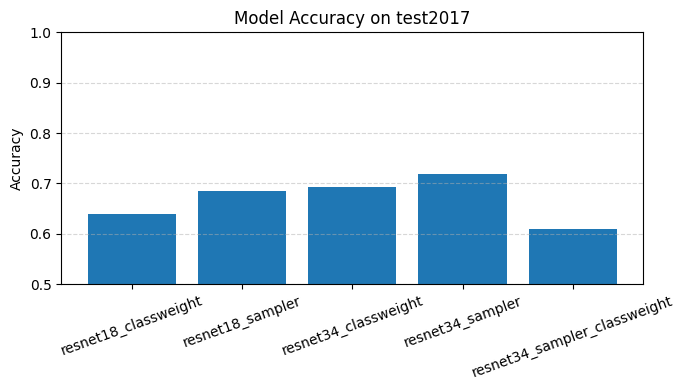

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

summary = pd.DataFrame([
    {"model": r["name"], "accuracy": r["acc"]}
    for r in results
])

display(summary)

plt.figure(figsize=(7,4))
plt.bar(summary["model"], summary["accuracy"])
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.title("Model Accuracy on test2017")
plt.xticks(rotation=20)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()

filepath = '../outputs/06_best_model_comparison/Model_Accuracy_on_test2017.jpg'

# 디렉토리 경로 추출
directory = os.path.dirname(filepath)

# 폴더가 없으면 생성 (중첩 폴더도 자동 생성)
os.makedirs(directory, exist_ok=True)

# 저장
plt.savefig(filepath, dpi=300)

plt.show()


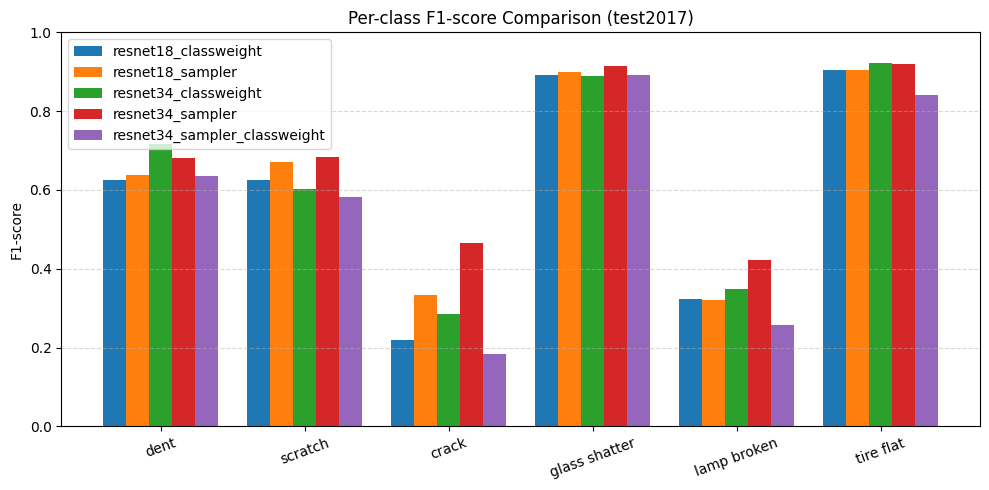

In [46]:
import numpy as np
import matplotlib.pyplot as plt

num_models = len(results)
num_classes = len(class_names)

x = np.arange(num_classes)   # 클래스 index (0~5)
width = 0.8 / num_models     # 막대 폭

plt.figure(figsize=(10,5))

for i, r in enumerate(results):
    offsets = x + (i - num_models/2) * width + width/2
    plt.bar(offsets, r["f1_per_class"], width=width, label=r["name"])

plt.xticks(x, class_names, rotation=20)
plt.ylim(0.0, 1.0)
plt.ylabel("F1-score")
plt.title("Per-class F1-score Comparison (test2017)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()

plt.savefig('../outputs/06_best_model_comparison/Per-class_F1-score_Comparison_(test2017).jpg', dpi=300)
plt.show()


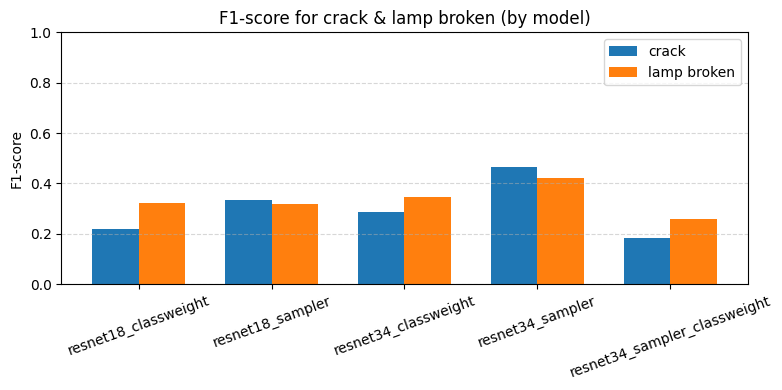

In [47]:
idx_crack = class_names.index("crack")
idx_lamp  = class_names.index("lamp broken")

models = [r["name"] for r in results]
f1_crack = [r["f1_per_class"][idx_crack] for r in results]
f1_lamp  = [r["f1_per_class"][idx_lamp]  for r in results]

x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(8,4))
plt.bar(x - width/2, f1_crack, width=width, label="crack")
plt.bar(x + width/2, f1_lamp,  width=width, label="lamp broken")

plt.xticks(x, models, rotation=20)
plt.ylim(0.0, 1.0)
plt.ylabel("F1-score")
plt.title("F1-score for crack & lamp broken (by model)")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig('../outputs/06_best_model_comparison/F1-score_for_crack _lamp_broken_(by model).jpg', dpi=300)
plt.show()


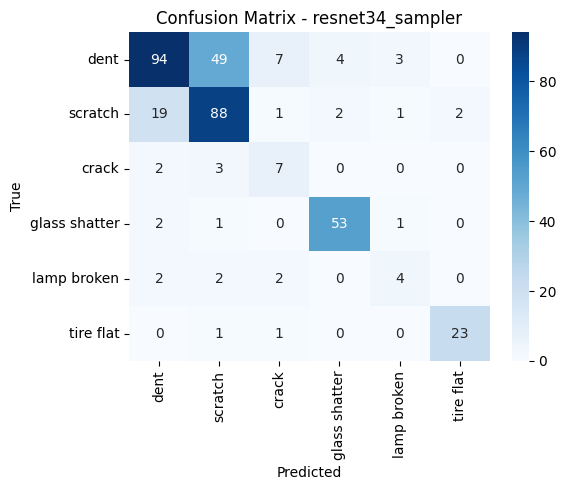

In [48]:
import seaborn as sns

def plot_confusion_matrix(cm, class_names, title="Confusion Matrix"):
    plt.figure(figsize=(6,5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.tight_layout()
    plt.savefig(f'../outputs/06_best_model_comparison/{title}.jpg', dpi=300)
    plt.show()

# 예: resnet34_sampler의 CM 보기
target_model_name = "resnet34_sampler"

for r in results:
    if r["name"] == target_model_name:
        plot_confusion_matrix(r["cm"], class_names, title=f"Confusion Matrix - {target_model_name}")
        break
